**Part a)** The first part is to split the data into three sets: training, validation, and test. Split each class separately so that there is an equal percentage of each class in all three sets. The number of total images in the validation is to be roughly 2000, in the test set 3000, and the remainder for the training set. It does not need to be exact. This is called a stratified split.

In [2]:
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import torch.optim as optim
from ResNet import ResNet

from sklearn.metrics import accuracy_score, average_precision_score

import matplotlib.pyplot as plt
import pandas as pd

device = torch.device('cuda') if torch.cuda.is_available else 'cpu'

First, we decide the classes. `.parts[-1]` gets out the last part in the directory, whilst `.iterdir()` iterates through directories, and `.is_dir()` sees to it, that it really is a directory.

In [3]:
dataset = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/mandatory1_data/')

classes = [str(subdir.parts[-1]) for subdir in dataset.iterdir() if subdir.is_dir()]
classes

['forest', 'buildings', 'sea', 'glacier', 'mountain', 'street']

Then, we create directories for `train, val, test` in the root folder

In [4]:
base_path = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/')

# the directories we want to create
dirs = ['train', 'val', 'test']

for dir_name in dirs:
    # creating a path string
    dir_path = base_path / dir_name
    dir_path.mkdir(parents=True, exist_ok=True) # creating directory

    # creating subdirectories of class names
    for class_name in classes:
        class_path = base_path / dir_name / class_name
        class_path.mkdir(parents=True, exist_ok=True)

Now we need to split the data into train, test, vals. A good way of doing this is to use `train_test_split` of the filenames and classes, and then fill our folders up.

In [5]:
img_paths = [] # container for image paths
class_indices = [] # container for class indices

for class_index, class_name in enumerate(classes):
    class_path = dataset / class_name
    for img_file in class_path.iterdir():
        if img_file.is_file():
            img_paths.append(img_file)
            class_indices.append(class_index)

In [6]:
train_imgs, temp_imgs, train_indices, temp_indices = train_test_split(
    img_paths, class_indices, test_size=0.3, stratify=class_indices, random_state=42
)

In [7]:
val_imgs, test_imgs, val_indices, test_indices = train_test_split(
    temp_imgs, temp_indices, test_size=0.6, stratify=temp_indices, random_state=42
)

In [8]:
def copy_images(img_paths, class_indices, split_name):
    
    for img_path, class_index in zip(img_paths, class_indices):
        target_dir = base_path / split_name / classes[class_index]
        target_file = target_dir / img_path.name

        # copying the file if it's not already there
        if not target_file.exists():
            shutil.copy(img_path, target_file)

In [9]:
copy_images(train_imgs, train_indices, 'train')
copy_images(val_imgs, val_indices, 'val')
copy_images(test_imgs, test_indices, 'test')

We now have folders with the data. Finally we can do a check for duplicates.

**Part b)** Create a solution to verify that the dataset splits are disjoint. Ensure that no file appears in more than one of your training, validation, or
test sets.

In [10]:
def verify_no_duplicates(train_imgs, val_imgs, test_imgs):
    train_set = set(train_imgs)
    val_set = set(val_imgs)
    test_set = set(test_imgs)

    # using intersection to check for data overlaps
    assert len(train_set.intersection(val_set)) == 0, 'Overlap between Train and Val'
    assert len(train_set.intersection(test_set)) == 0, 'Overlap between Train and Test'
    assert len(val_set.intersection(test_set)) == 0, 'Overlap between Val and Test'

verify_no_duplicates(train_imgs, val_imgs, test_imgs)

**Part c)** Develop and implement dataloaders for training, validation, and test sets. Please make one root path for the dataset, this makes it easier for us
to check/debug your work. If there are multiple paths to the dataset that we need to change, it becomes tricky to change them all.

In [11]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(), # converts to a torch tensor
    transforms.Normalize((0.5,), (0.5,)) # normalizes to [-1, 1]
])

augment_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),  # flipping image (P=50%)
    transforms.RandomRotation(15),  # rotating ±15 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # cropping randomly and scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Endrer farger
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

In [12]:
train_dataset = datasets.ImageFolder(root=base_path / 'train', transform=transform)
train_dataset_augm = datasets.ImageFolder(root=base_path / 'train', transform=augment_transform)
val_dataset = datasets.ImageFolder(root=base_path / 'val', transform=transform)
test_dataset = datasets.ImageFolder(root=base_path / 'test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_loader_augm = DataLoader(train_dataset_augm, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

2b) Use the dataloaders you created in Part 1 to feed
the training data into the model of your choosing. Write code to perform the training process, ensuring that the model is optimized over the training data. Make sure to use the validation dataset to monitor performance during training. During training, monitor the model’s performance using accuracy on the validation set. This will give you an initial indication of how well your model is learning.

In [13]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    val_loss = running_loss / len(dataloader)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)

    ap_scores = []
    class_accs = []
    num_classes = all_probs.shape[1]

    for i in range(all_probs.shape[1]):
        binary_labels = (all_labels == i).float()
        ap = average_precision_score(binary_labels.cpu().numpy(), all_probs[:, i].cpu().numpy())
        ap_scores.append(ap)

        class_correct = ((all_preds == i) & (all_labels == i)).sum().item()
        class_total = (all_labels == i).sum().item()
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        class_accs.append(class_accuracy)

    map_score = sum(ap_scores) / len(ap_scores)

    return accuracy, val_loss, map_score, class_accs

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, file_path, num_epochs=10, early_stopping=5):
    model = model.to(device)

    train_accs, val_accs, map_scores, class_accs = [], [], [], []
    train_losses, val_losses = [], []
    best_map_score = 0.0
    epochs_no_improvement = 0

    for epoch in range(num_epochs):
        model.train()  # Treningsmodus
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        val_accuracy, val_loss, map_score, class_acc = evaluate_model(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        map_scores.append(map_score)
        class_accs.append(class_acc)

        if map_score > best_map_score:
            torch.save(model.state_dict(), file_path)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, mAP: {map_score:.4f} - Model Saved")
            best_map_score = map_score
            epochs_no_improvement = 0

        else:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, mAP: {map_score:.4f}")
            epochs_no_improvement += 1

        if epochs_no_improvement > early_stopping:
            print("Early stopping!")
            break

    return train_accs, val_accs, map_scores, class_accs, train_losses, val_losses


In [17]:
criterion = nn.CrossEntropyLoss()
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
optimizer = optim.Adam(model.parameters(), lr=0.001)
file_path = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet1.pth'
train_acc1, val_acc1, map_scores1, class_accs1, train_losses1, val_losses1 = train_model(model, train_loader, val_loader, criterion, optimizer, file_path, num_epochs=15)

Epoch 1/15, Train Loss: 1.0641, Val Loss: 0.8574, Train Acc: 0.5832, Val Acc: 0.6844, mAP: 0.7539 - Model Saved
Epoch 2/15, Train Loss: 0.7461, Val Loss: 0.6880, Train Acc: 0.7246, Val Acc: 0.7524, mAP: 0.8364 - Model Saved
Epoch 3/15, Train Loss: 0.6196, Val Loss: 0.8499, Train Acc: 0.7747, Val Acc: 0.7016, mAP: 0.8173
Epoch 4/15, Train Loss: 0.5500, Val Loss: 0.5554, Train Acc: 0.8027, Val Acc: 0.7891, mAP: 0.8898 - Model Saved
Epoch 5/15, Train Loss: 0.5004, Val Loss: 0.4790, Train Acc: 0.8192, Val Acc: 0.8327, mAP: 0.9079 - Model Saved
Epoch 6/15, Train Loss: 0.4622, Val Loss: 0.4765, Train Acc: 0.8349, Val Acc: 0.8337, mAP: 0.9022
Epoch 7/15, Train Loss: 0.4344, Val Loss: 0.4440, Train Acc: 0.8457, Val Acc: 0.8459, mAP: 0.9165 - Model Saved
Epoch 8/15, Train Loss: 0.4003, Val Loss: 0.4360, Train Acc: 0.8599, Val Acc: 0.8518, mAP: 0.9163
Epoch 9/15, Train Loss: 0.3865, Val Loss: 0.6807, Train Acc: 0.8607, Val Acc: 0.7730, mAP: 0.8678
Epoch 10/15, Train Loss: 0.3576, Val Loss: 0.438

In [18]:
criterion = nn.CrossEntropyLoss()
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
optimizer = optim.Adam(model.parameters(), lr=0.001)
file_path = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet2.pth'
train_acc2, val_acc2, map_scores2, class_accs2, train_losses2, val_losses2 = train_model(model, train_loader_augm, val_loader, criterion, optimizer, file_path, num_epochs=15)

Epoch 1/15, Train Loss: 1.2044, Val Loss: 1.0853, Train Acc: 0.5182, Val Acc: 0.5372, mAP: 0.6669 - Model Saved
Epoch 2/15, Train Loss: 0.9320, Val Loss: 0.7589, Train Acc: 0.6394, Val Acc: 0.7099, mAP: 0.7966 - Model Saved
Epoch 3/15, Train Loss: 0.7949, Val Loss: 0.8104, Train Acc: 0.7078, Val Acc: 0.7114, mAP: 0.8340 - Model Saved
Epoch 4/15, Train Loss: 0.6978, Val Loss: 0.6762, Train Acc: 0.7418, Val Acc: 0.7471, mAP: 0.8656 - Model Saved
Epoch 5/15, Train Loss: 0.6535, Val Loss: 1.0786, Train Acc: 0.7626, Val Acc: 0.6394, mAP: 0.7912
Epoch 6/15, Train Loss: 0.6063, Val Loss: 0.9097, Train Acc: 0.7845, Val Acc: 0.6634, mAP: 0.8327
Epoch 7/15, Train Loss: 0.5719, Val Loss: 0.5377, Train Acc: 0.7952, Val Acc: 0.8033, mAP: 0.8881 - Model Saved
Epoch 8/15, Train Loss: 0.5359, Val Loss: 0.4646, Train Acc: 0.8052, Val Acc: 0.8381, mAP: 0.9083 - Model Saved
Epoch 9/15, Train Loss: 0.5151, Val Loss: 0.5620, Train Acc: 0.8179, Val Acc: 0.8048, mAP: 0.8973
Epoch 10/15, Train Loss: 0.5134, V

In [19]:
criterion = nn.CrossEntropyLoss()
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
optimizer = optim.SGD(model.parameters(), lr=0.001)
file_path = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet3.pth'
train_acc3, val_acc3, map_scores3, class_accs3, train_losses3, val_losses3 = train_model(model, train_loader, val_loader, criterion, optimizer, file_path, num_epochs=15)

Epoch 1/15, Train Loss: 1.2068, Val Loss: 1.0496, Train Acc: 0.5183, Val Acc: 0.5871, mAP: 0.6769 - Model Saved
Epoch 2/15, Train Loss: 0.8068, Val Loss: 1.7209, Train Acc: 0.6960, Val Acc: 0.5298, mAP: 0.6253
Epoch 3/15, Train Loss: 0.6470, Val Loss: 0.8543, Train Acc: 0.7635, Val Acc: 0.6844, mAP: 0.8011 - Model Saved
Epoch 4/15, Train Loss: 0.5485, Val Loss: 1.4463, Train Acc: 0.8024, Val Acc: 0.5920, mAP: 0.7419
Epoch 5/15, Train Loss: 0.4805, Val Loss: 0.7053, Train Acc: 0.8294, Val Acc: 0.7471, mAP: 0.8292 - Model Saved
Epoch 6/15, Train Loss: 0.4227, Val Loss: 0.5077, Train Acc: 0.8504, Val Acc: 0.8229, mAP: 0.8959 - Model Saved
Epoch 7/15, Train Loss: 0.3740, Val Loss: 0.5565, Train Acc: 0.8698, Val Acc: 0.8072, mAP: 0.8936
Epoch 8/15, Train Loss: 0.3276, Val Loss: 0.7803, Train Acc: 0.8874, Val Acc: 0.7383, mAP: 0.8631
Epoch 9/15, Train Loss: 0.2855, Val Loss: 0.5595, Train Acc: 0.9032, Val Acc: 0.8131, mAP: 0.8974 - Model Saved
Epoch 10/15, Train Loss: 0.2404, Val Loss: 0.507

In [20]:
criterion = nn.CrossEntropyLoss()
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
optimizer = optim.Adam(model.parameters(), lr=0.005)
file_path = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet1.pth'
train_acc4, val_acc4, map_scores4, class_accs4, train_losses4, val_losses4 = train_model(model, train_loader, val_loader, criterion, optimizer, file_path, num_epochs=15)

Epoch 1/15, Train Loss: 1.2723, Val Loss: 1.0632, Train Acc: 0.4838, Val Acc: 0.5602, mAP: 0.6107 - Model Saved
Epoch 2/15, Train Loss: 0.9811, Val Loss: 0.9247, Train Acc: 0.6038, Val Acc: 0.6199, mAP: 0.7106 - Model Saved
Epoch 3/15, Train Loss: 0.8322, Val Loss: 0.7114, Train Acc: 0.6774, Val Acc: 0.7285, mAP: 0.8057 - Model Saved
Epoch 4/15, Train Loss: 0.7009, Val Loss: 0.7451, Train Acc: 0.7394, Val Acc: 0.7260, mAP: 0.8361 - Model Saved
Epoch 5/15, Train Loss: 0.6158, Val Loss: 0.5640, Train Acc: 0.7762, Val Acc: 0.7975, mAP: 0.8758 - Model Saved
Epoch 6/15, Train Loss: 0.5562, Val Loss: 0.5305, Train Acc: 0.7986, Val Acc: 0.8087, mAP: 0.8901 - Model Saved
Epoch 7/15, Train Loss: 0.5089, Val Loss: 0.6970, Train Acc: 0.8129, Val Acc: 0.7441, mAP: 0.8529
Epoch 8/15, Train Loss: 0.4616, Val Loss: 0.5070, Train Acc: 0.8313, Val Acc: 0.8200, mAP: 0.8961 - Model Saved
Epoch 9/15, Train Loss: 0.4330, Val Loss: 0.4760, Train Acc: 0.8443, Val Acc: 0.8312, mAP: 0.9099 - Model Saved
Epoch 

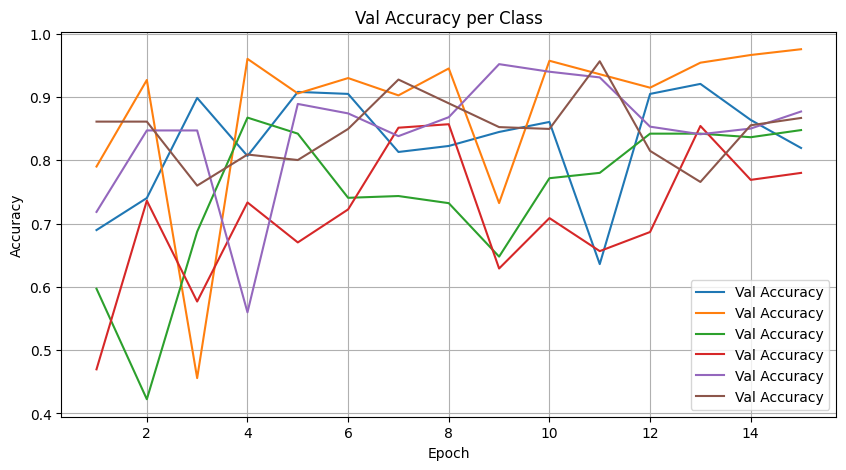

In [23]:
epochs = range(1, len(train_acc1) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, class_accs1, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Val Accuracy per Class")
plt.legend()
plt.grid(True)
plt.show()

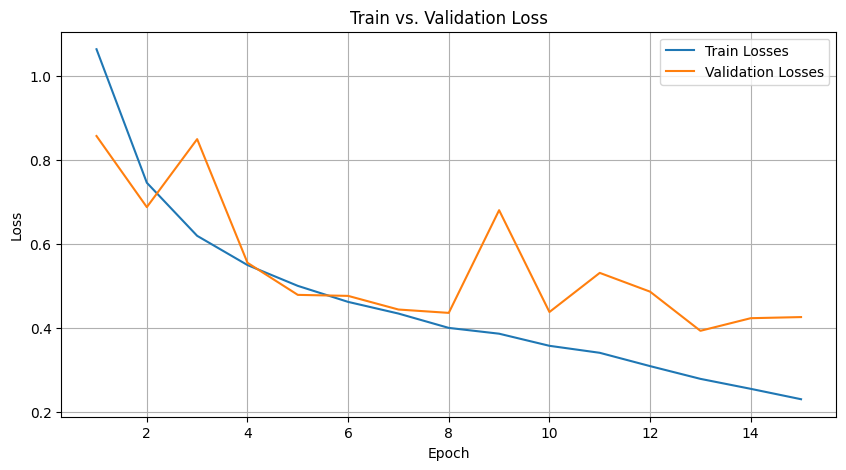

In [24]:
epochs = range(1, len(train_acc1) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses1, label="Train Losses")
plt.plot(epochs, val_losses1, label="Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()